# A Simple Autoencoder

We'll start off by building a simple autoencoder to compress the MNIST dataset. With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data. Generally the encoder and decoder will be built with neural networks, then trained on example data.

![Autoencoder](assets/autoencoder_1.png)

In this notebook, we'll be build a simple network architecture for the encoder and decoder. Let's get started by importing our libraries and getting the dataset.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import PIL

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Below I'm plotting an example image from the MNIST dataset. These are 28x28 grayscale images of handwritten digits.

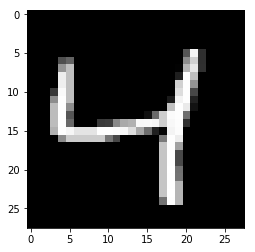

In [4]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

We'll train an autoencoder with these images by flattening them into 784 length vectors. The images from this dataset are already normalized such that the values are between 0 and 1. Let's start by building basically the simplest autoencoder with a **single ReLU hidden layer**. This layer will be used as the compressed representation. Then, the encoder is the input layer and the hidden layer. The decoder is the hidden layer and the output layer. Since the images are normalized between 0 and 1, we need to use a **sigmoid activation on the output layer** to get values matching the input.

![Autoencoder architecture](assets/simple_autoencoder.png)


> **Exercise:** Build the graph for the autoencoder in the cell below. The input images will be flattened into 784 length vectors. The targets are the same as the inputs. And there should be one hidden layer with a ReLU activation and an output layer with a sigmoid activation. Feel free to use TensorFlow's higher level API, `tf.layers`. For instance, you would use [`tf.layers.dense(inputs, units, activation=tf.nn.relu)`](https://www.tensorflow.org/api_docs/python/tf/layers/dense) to create a fully connected layer with a ReLU activation. The loss should be calculated with the cross-entropy loss, there is a convenient TensorFlow function for this `tf.nn.sigmoid_cross_entropy_with_logits` ([documentation](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits)). You should note that `tf.nn.sigmoid_cross_entropy_with_logits` takes the logits, but to get the reconstructed images you'll need to pass the logits through the sigmoid function.

In [5]:
# Size of the encoding layer (the hidden layer)
encoding_dim = 78 # feel free to change this value
init_stddev = 1./np.sqrt(encoding_dim)

# Input and target placeholders
data_dim = 784
inputs_ = tf.placeholder(tf.float32, shape=(None, 784))
targets_ = tf.placeholder(tf.float32, shape=(None, 784))

# Output of hidden layer, single fully connected layer here with ReLU activation
weights = tf.Variable(tf.random_normal((data_dim, encoding_dim), stddev=init_stddev))
bias = tf.Variable(tf.zeros(encoding_dim))
encoded = tf.nn.relu(tf.add(tf.matmul(inputs_, weights), bias))

# Output layer logits, fully connected layer with no activation
weights_out = tf.Variable(tf.random_normal((encoding_dim, data_dim), stddev=init_stddev))
bias_out = tf.Variable(tf.zeros(data_dim))
logits = tf.add(tf.matmul(encoded, weights_out), bias_out)
# Sigmoid output from logits
decoded = tf.nn.sigmoid(logits)

# Sigmoid cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
# Mean of the loss
cost = tf.reduce_mean(loss)

# Adam optimizer
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

## Training

In [6]:
# Create the session
sess = tf.Session()

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss. 

Calling `mnist.train.next_batch(batch_size)` will return a tuple of `(images, labels)`. We're not concerned with the labels here, we just need the images. Otherwise this is pretty straightfoward training with TensorFlow. We initialize the variables with `sess.run(tf.global_variables_initializer())`. Then, run the optimizer and get the loss with `batch_cost, _ = sess.run([cost, opt], feed_dict=feed)`.

In [7]:
epochs = 20
batch_size = 1000
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    costs = []
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        feed = {inputs_: batch[0], targets_: batch[0]}
        batch_cost, _ = sess.run([cost, opt], feed_dict=feed)
        costs.append(batch_cost)

    print("Epoch: {}/{}...".format(e+1, epochs),
          "Training loss: {:.4f}".format(np.mean(np.array(costs))))

Epoch: 1/20... Training loss: 0.4244
Epoch: 2/20... Training loss: 0.2219
Epoch: 3/20... Training loss: 0.1784
Epoch: 4/20... Training loss: 0.1531
Epoch: 5/20... Training loss: 0.1365
Epoch: 6/20... Training loss: 0.1250
Epoch: 7/20... Training loss: 0.1165
Epoch: 8/20... Training loss: 0.1100
Epoch: 9/20... Training loss: 0.1048
Epoch: 10/20... Training loss: 0.1005
Epoch: 11/20... Training loss: 0.0969
Epoch: 12/20... Training loss: 0.0938
Epoch: 13/20... Training loss: 0.0913
Epoch: 14/20... Training loss: 0.0891
Epoch: 15/20... Training loss: 0.0872
Epoch: 16/20... Training loss: 0.0855
Epoch: 17/20... Training loss: 0.0840
Epoch: 18/20... Training loss: 0.0827
Epoch: 19/20... Training loss: 0.0816
Epoch: 20/20... Training loss: 0.0806


## Save

In [15]:
saver = tf.train.Saver()
saver.save(sess, 'model.ckpt')

'model.ckpt'

## Restore

In [31]:
saver = tf.train.Saver()
saver.restore(sess, 'model.ckpt')

INFO:tensorflow:Restoring parameters from model.ckpt


InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [784,78] rhs shape= [784]
	 [[Node: save_5/Assign_24 = Assign[T=DT_FLOAT, _class=["loc:@Variable_16"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](Variable_16, save_5/RestoreV2_24)]]

Caused by op 'save_5/Assign_24', defined at:
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-63a3fabe5947>", line 1, in <module>
    saver = tf.train.Saver()
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1056, in __init__
    self.build()
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1086, in build
    restore_sequentially=self._restore_sequentially)
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 691, in build
    restore_sequentially, reshape)
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 419, in _AddRestoreOps
    assign_ops.append(saveable.restore(tensors, shapes))
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 155, in restore
    self.op.get_shape().is_fully_defined())
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 270, in assign
    validate_shape=validate_shape)
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 47, in assign
    use_locking=use_locking, name=name)
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [784,78] rhs shape= [784]
	 [[Node: save_5/Assign_24 = Assign[T=DT_FLOAT, _class=["loc:@Variable_16"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](Variable_16, save_5/RestoreV2_24)]]


## Checking out the results

Below I've plotted some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

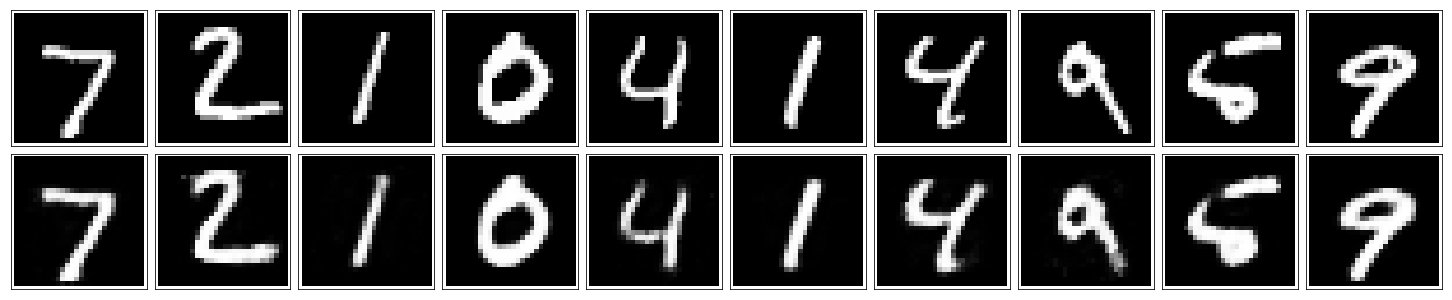

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed, compressed = sess.run([decoded, encoded], feed_dict={inputs_: in_imgs})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [9]:
def remap(x, low_in, high_in, low_out, high_out):
    return (x - low_in)/(high_in-low_in)*(high_out-low_out) + low_out

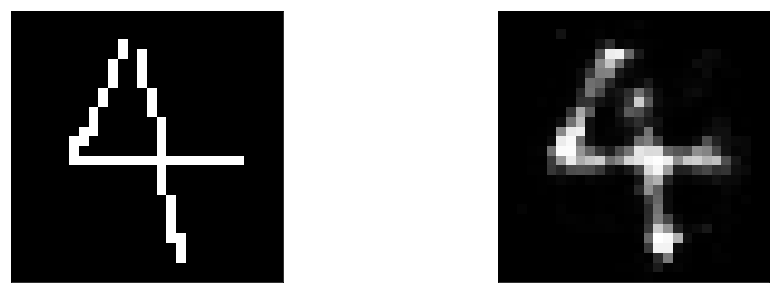

In [14]:
img = PIL.Image.open('./fun/4.png').convert('L')
img_arr = np.asarray(img, dtype=np.float32).reshape((-1))
img_arr_rm = remap(img_arr, 255, 0, 0, 1)
reconstructed, compressed = sess.run([decoded, encoded], feed_dict={inputs_: [img_arr_rm]})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
axes[0].imshow(img_arr_rm.reshape((28,28)), cmap='Greys_r')
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[1].imshow(reconstructed.reshape((28,28)), cmap='Greys_r')
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)

In [16]:
sess.close()

## Up Next

We're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.

In practice, autoencoders aren't actually better at compression compared to typical methods like JPEGs and MP3s. But, they are being used for noise reduction, which you'll also build.